In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head(10)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [4]:
duplicate_rows_data = train[train.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_data.shape)

Number of duplicate rows:  (0, 6)


In [5]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T.drop('count', axis = 1)], axis = 1)
desc

,count,nunique,%unique,null,type,mean,std,min,25%,50%,75%,max
id,136950,136950,100.000000,0,int64,68474.500000,39534.204020,0.0,34237.25,68474.5,102711.75,136949.0
date,136950,1826,1.333333,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store,136950,3,0.002191,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product,136950,5,0.003651,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_sold,136950,1028,0.750639,0,int64,165.522636,183.691575,2.0,46.00,98.0,184.00,1380.0


In [6]:
# feature recasting, cast date as datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [7]:
#plt.figure(figsize = (20, 10), dpi = 300)

#sns.lineplot(data = train, x = 'date', y = 'num_sold')
    
#plt.title('Sales Over Time', fontsize = 24, fontweight = 'bold')
#plt.show()

In [8]:
#plt.figure(figsize = (20, 10), dpi = 300)

#sns.lineplot(data = train, x = 'date', y = 'num_sold', hue = 'country')
    
#plt.title('Sales Over Time per Country', fontsize = 24, fontweight = 'bold')
#plt.show()

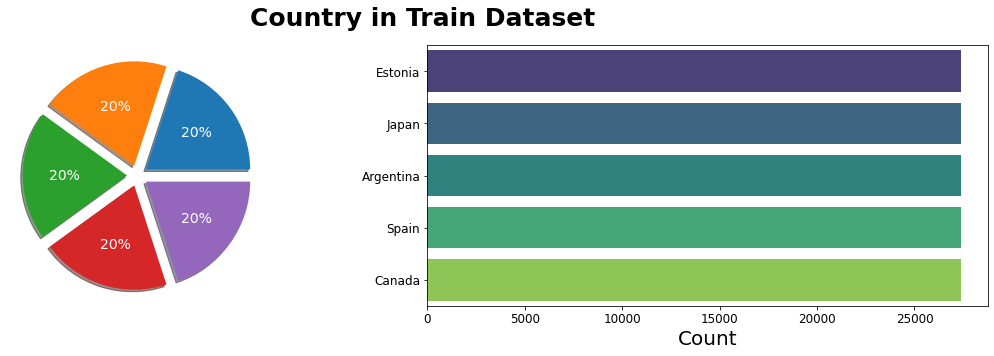

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['country'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 5)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'country', ax = ax[1], palette = 'viridis', order = train['country'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Country in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

In [10]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021, 2022]

    holiday_AR = holidays.CountryHoliday('AR', years=years_list)
    holiday_CA = holidays.CountryHoliday('CA', years=years_list)
    holiday_EE = holidays.CountryHoliday('EE', years=years_list)
    holiday_JP = holidays.CountryHoliday('JP', years=years_list)
    holiday_ES = holidays.CountryHoliday('ES', years=years_list)

    holiday_dict = holiday_AR.copy()
    holiday_dict.update(holiday_CA)
    holiday_dict.update(holiday_EE)
    holiday_dict.update(holiday_JP)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')

    return df

# Assume enc is an instance of OrdinalEncoder()
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

In [11]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train = get_holidays(train)
test = get_holidays(test)

# Create features from 'date'
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek

# Fill NA values caused by moving average
train = train.fillna(method='bfill')

# One-hot encoding
train = pd.get_dummies(train, columns=['country', 'store', 'product'])

# Define features X and target y
X = train.drop(['id', 'date', 'num_sold'], axis=1)
y = train[['num_sold']]

y = train[['num_sold']]
X = train.drop(['id','num_sold', 'date'], axis=1)

### Do same for test data set
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek

# One-hot encoding
test = pd.get_dummies(test, columns=['country', 'store', 'product'])

ids = test['id']
test = test.drop(['id', 'date'], axis=1)

X = encode_holiday_names(X, oe)
test = encode_holiday_names(test, oe)

In [12]:
X.head(10)

,holiday_name,is_holiday,year,month,day,dayofweek,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,50.0,1,2017,1,1,6,1,0,0,0,0,0,1,0,1,0,0,0,0
1,50.0,1,2017,1,1,6,1,0,0,0,0,0,1,0,0,1,0,0,0
2,50.0,1,2017,1,1,6,1,0,0,0,0,0,1,0,0,0,1,0,0
3,50.0,1,2017,1,1,6,1,0,0,0,0,0,1,0,0,0,0,1,0
4,50.0,1,2017,1,1,6,1,0,0,0,0,0,1,0,0,0,0,0,1
5,50.0,1,2017,1,1,6,1,0,0,0,0,0,0,1,1,0,0,0,0
6,50.0,1,2017,1,1,6,1,0,0,0,0,0,0,1,0,1,0,0,0
7,50.0,1,2017,1,1,6,1,0,0,0,0,0,0,1,0,0,1,0,0
8,50.0,1,2017,1,1,6,1,0,0,0,0,0,0,1,0,0,0,1,0
9,50.0,1,2017,1,1,6,1,0,0,0,0,0,0,1,0,0,0,0,1


In [13]:
test.head(10)

,holiday_name,is_holiday,year,month,day,dayofweek,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,1.0,1,2022,1,1,5,1,0,0,0,0,0,1,0,1,0,0,0,0
1,1.0,1,2022,1,1,5,1,0,0,0,0,0,1,0,0,1,0,0,0
2,1.0,1,2022,1,1,5,1,0,0,0,0,0,1,0,0,0,1,0,0
3,1.0,1,2022,1,1,5,1,0,0,0,0,0,1,0,0,0,0,1,0
4,1.0,1,2022,1,1,5,1,0,0,0,0,0,1,0,0,0,0,0,1
5,1.0,1,2022,1,1,5,1,0,0,0,0,0,0,1,1,0,0,0,0
6,1.0,1,2022,1,1,5,1,0,0,0,0,0,0,1,0,1,0,0,0
7,1.0,1,2022,1,1,5,1,0,0,0,0,0,0,1,0,0,1,0,0
8,1.0,1,2022,1,1,5,1,0,0,0,0,0,0,1,0,0,0,1,0
9,1.0,1,2022,1,1,5,1,0,0,0,0,0,0,1,0,0,0,0,1


In [14]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import RegressorChain


lgbm = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42)
xgb =  RegressorChain(base_estimator=XGBRegressor(max_depth= 7, n_estimators= 200,learning_rate= 0.01, random_state=42))


In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scaler = StandardScaler()
xgb_scores = list()
lgbm_scores = list()

for train_ix, valid_ix in skf.split(X, y):
    X_train, X_valid = X.iloc[train_ix], X.iloc[valid_ix]
    y_train, y_valid = y.iloc[train_ix], y.iloc[valid_ix]
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_valid_scaled = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
    
    lgbm.fit(X_train_scaled, y_train) 
    xgb.fit(X_train_scaled, y_train)
    
    xgb_predict = xgb.predict(X_valid_scaled)
    lgbm_predict = lgbm.predict(X_valid_scaled)
    

c:\users\jason nguyen\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\jason nguyen\appdata\local\programs\python\python36\lib\site-packages\joblib\externals\loky\backend\context.py:152: UserWarning: Could not find the number of physical cores for the following reason:
__init__() got an unexpected keyword argument 'capture_output'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  "following reason:\n" + str(exception) + "\n"
  File "c:\users\jason nguyen\appdata\local\programs\python\python36\lib\site-packages\joblib\externals\loky\backend\context.py", line 229, in _count_physical_cores
    capture_output=True)
  File "c:\users\jason nguyen\appdata\local\programs\python\python36\lib\subprocess.p

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 109560, number of used features: 19
[LightGBM] [Info] Start training from score 165.534237
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 109560, number of used features: 19
[LightGBM] [Info] Start training from score 165.509940
[LightGBM] [Warnin

In [17]:
lgbm_predict

array([ 58.88297669,  82.2182796 , 253.13665922, ..., 747.2971035 ,
       724.963299  , 674.38363888])

In [18]:
xgb_predict

array([[ 31.31064796],
       [ 45.59279633],
       [148.27885437],
       ...,
       [420.74325562],
       [415.81509399],
       [393.25616455]])

In [19]:
y_pred = lgbm.predict(test)
y_pred

array([ 41.33946835,  35.32153345,   3.30844942, ..., 114.94640276,
       713.93361849, 579.17166567])

In [20]:
submit = pd.DataFrame(y_pred, columns = ['num_sold'])

submit['id'] = ids
submit = submit[['id','num_sold']]

submit.head()

,id,num_sold
0,136950,41.339468
1,136951,35.321533
2,136952,3.308449
3,136953,31.542903
4,136954,18.358110


In [22]:
submit.to_csv('submission5.csv', index=False)

In [21]:
submit

,id,num_sold
0,136950,41.339468
1,136951,35.321533
2,136952,3.308449
3,136953,31.542903
4,136954,18.358110
...,...,...
27370,164320,774.490279
27371,164321,752.680846
27372,164322,114.946403
27373,164323,713.933618
